# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [87]:
#Import the libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Exploration

### 1.1 Exploring the Portfolio dataset

In [3]:
#print the shape of portfolio dataset
portfolio.shape

(10, 6)

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
#print the shape of profile dataset
profile.shape


(17000, 5)

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [9]:
def plot_bar_graph(df,colname,title):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    
    df: The input dataframe
    
    colname: The name of the column containing the categories
    
    title: The title of the plot
    
    Returns None
    """
    plt.figure(figsize=(7,5))
    column_counts = df[colname].value_counts()
    fig,ax = plt.subplots()
    column_counts.plot(kind='barh')
    for index,value in enumerate(column_counts):
        ax.text(value,index,str(value),color='black',fontsize=12,fontweight='bold')
        plt.title(title)

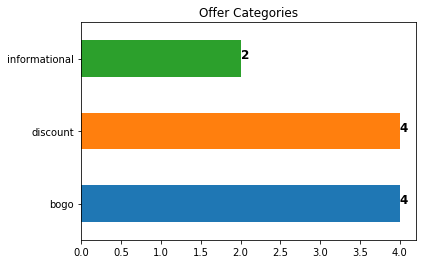

In [10]:
plot_bar_graph(portfolio,"offer_type","Offer Categories");

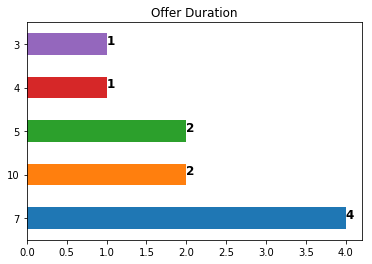

In [11]:
plot_bar_graph(portfolio,"duration","Offer Duration");

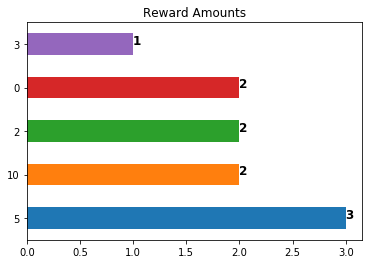

In [12]:
plot_bar_graph(portfolio,"reward","Reward Amounts")

### 1.2 Exploring the Profile dataset

In [13]:
#print the shape of profile dataset
profile.shape

(17000, 5)

In [14]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [16]:
profile.describe(include='all')

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,8fd1b23ea1874f6d9b1f3b2bf0024cb0,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


In [17]:
age_counts = profile['age'].value_counts()

In [18]:
age_counts

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [19]:
#Count the number of null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Looks like there are 2175 missing values in gender and income columns

In [20]:
null_df = profile[(profile['gender'].isnull()) | (profile['income'].isnull())]

In [21]:
null_df.shape

(2175, 5)

In [22]:
null_df.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


Looks like all the customers with age 118 have their gender and income values missing

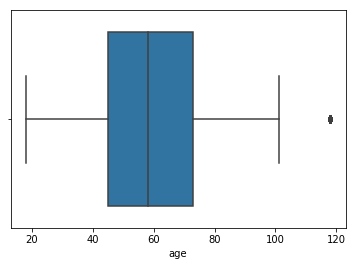

In [23]:
sns.boxplot(profile['age'])

From the above box plot we can conclude that the app is mostly used by people of age between 40 and 80

In [24]:
#Exploring the gender distribution
gender_counts = profile['gender'].value_counts()

In [25]:
gender_counts

M    8484
F    6129
O     212
Name: gender, dtype: int64

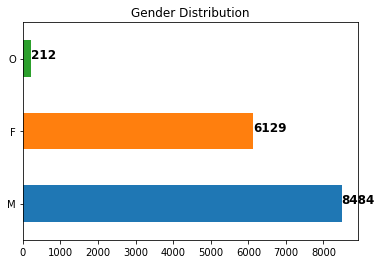

In [26]:
plot_bar_graph(profile,'gender','Gender Distribution')

Text(0.5,1,'Gender Distribution')

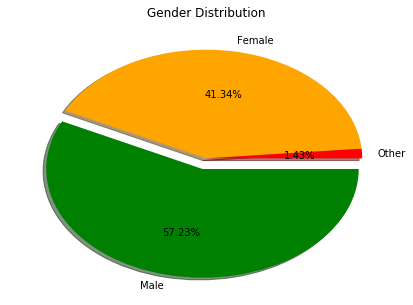

In [27]:
plt.figure(figsize=(7,5))
plt.pie(gender_counts,colors=['green','orange','red'],labels=['Male','Female','Other'],autopct='%1.2f%%',counterclock=False, shadow=True,explode=(0.1,0,0))
plt.title("Gender Distribution")

### 1.3 Exploring the Transcript dataset

In [28]:
#printing the shape of the transcript dataset
transcript.shape

(306534, 4)

In [29]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [30]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [31]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [32]:
#count the number of null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

Looks like the dataset is clean

In [33]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

## 2. Data Wrangling

In [37]:
#Rename the columns of the portfolio dataframe
portfolio = portfolio.rename(columns={'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'})

In [38]:
portfolio.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [39]:
#Rename the columns of the profile dataframe
profile = profile.rename(columns={'id':'customer_id' , 'income':'customer_income'})


In [40]:
profile.head()

,age,became_member_on,gender,customer_id,customer_income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


- I will impute the missing values in age and gender column by using mean and mode
- All the customers with age above 80 are considered as outliers so drop them from the dataset
- And also it would be better if we classify customers in to diffent groups based on their age
  - Below 20
  - Between 20 - 45
  - Between 46 - 60
  - Between 61 - 80


In [41]:
def clean_profile_df(df):
    '''
    Cleans the profile dataframe by doing some operations
    
    Parameters df (Dataframe)
    Returns a datafarme
    '''
    #replace all values of age 118 with NaN
    df.replace(118, np.nan , inplace=True)
    
    #replace Nan age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    
    #replace missing gender values with mode i.e with the most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    #remove the outliers i.e users of age above 80 are considered as outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add new Age group column
    df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'Age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [42]:
profile = clean_profile_df(profile)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [43]:
profile.head()

,became_member_on,gender,customer_id,customer_income,Age_group
0,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,46-60
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,46-60
2,20180712,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,46-60
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,61-80
4,20170804,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,46-60


In [44]:
#print the shape
profile.shape

(16014, 5)

In [45]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 5 columns):
became_member_on    16014 non-null int64
gender              16014 non-null object
customer_id         16014 non-null object
customer_income     16014 non-null float64
Age_group           16014 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 750.7+ KB


In [46]:
profile.describe()

,became_member_on,customer_income
count,1.601400e+04,16014.000000
mean,2.016705e+07,65012.043004
std,1.172463e+04,19963.587688
min,2.013073e+07,30000.000000
25%,2.016053e+07,51000.000000
50%,2.017080e+07,65404.991568
75%,2.017123e+07,75000.000000
max,2.018073e+07,120000.000000


In [47]:
#check if the dataset has null values after cleaning
profile.isnull().sum()

became_member_on    0
gender              0
customer_id         0
customer_income     0
Age_group           0
dtype: int64

In [48]:
#Now Clean the Transcript dataset
transcript = transcript.rename(columns={'person':'customer_id'})

In [49]:
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [50]:
transcript.columns

Index(['event', 'customer_id', 'time', 'value'], dtype='object')

In [54]:
def clean_transcript_df(df):
    '''
    Cleans the transcript dataframe
    
    Parameters df (Data Frame)
    
    Returns a dataframe
    '''
    #Extract the offer id ,reward amount and amount spent from the value column
    #In the values column there are two keys offer id and offer_id
    df['offer_id'] = df['value'].apply(lambda x : x.get('offer_id') if x.get('offer_id') else x.get('offer id'))
    df['amount_spent'] = df['value'].apply(lambda x : x.get('amount'))
    df['amount_gained'] = df['value'].apply(lambda x : x.get('reward'))
    
    #Drop the value column
    df.drop('value',axis=1,inplace=True)
    
    #Replace all the missing with values with 0
    df.fillna(0,inplace=True)
    return df


In [55]:
transcript = clean_transcript_df(transcript)

In [56]:
transcript.shape

(306534, 6)

In [57]:
transcript.columns

Index(['event', 'customer_id', 'time', 'offer_id', 'amount_spent',
       'amount_gained'],
      dtype='object')

In [59]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event            306534 non-null object
customer_id      306534 non-null object
time             306534 non-null int64
offer_id         306534 non-null object
amount_spent     306534 non-null float64
amount_gained    306534 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [58]:
#check if the dataframe has null values after cleaning
transcript.isnull().sum()

event            0
customer_id      0
time             0
offer_id         0
amount_spent     0
amount_gained    0
dtype: int64

In [60]:
transcript.describe()

,time,amount_spent,amount_gained
count,306534.000000,306534.000000,306534.000000
mean,366.382940,5.792023,0.537219
std,200.326314,21.337137,1.805208
min,0.000000,0.000000,0.000000
25%,186.000000,0.000000,0.000000
50%,408.000000,0.000000,0.000000
75%,528.000000,7.100000,0.000000
max,714.000000,1062.280000,10.000000


Now we need to merge all the three dataframes (portfolio,profile,transcript) into a single dataframe

In [61]:
#By default merge uses inner join
merged_df = portfolio.merge(transcript,on='offer_id')
merged_df = merged_df.merge(profile,on='customer_id')

In [62]:
merged_df.shape

(157503, 15)

In [63]:
merged_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,amount_spent,amount_gained,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,10.0,20170909,M,100000.0,61-80


## 3. Data Exploration

In [64]:
#Lets try to find the average income of the customers
merged_df['customer_income'].mean()

65924.491099765321

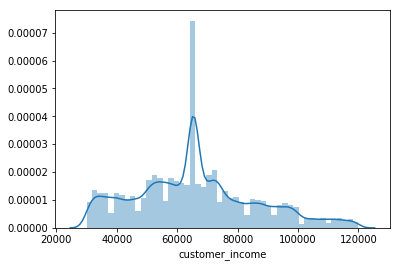

In [66]:
sns.distplot(merged_df['customer_income'], bins=50, hist_kws={'alpha': 0.4});

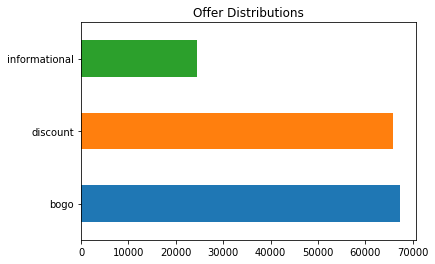

In [69]:
#Lets try to find the offer which is used by most of the customers
merged_df['offer_type'].value_counts().plot.barh(title='Offer Distributions');

From the above bar graph it seems like both discount and bogo caught most customer attention

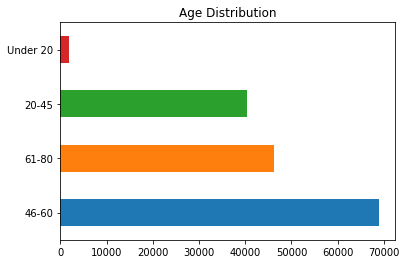

In [71]:
#Now lets try to find the age distribution of the customers
merged_df['Age_group'].value_counts().plot.barh(title='Age Distribution')

Its quite surprising to find that most of the customers are in the 46 - 60 age group but not in the 20 - 45 group

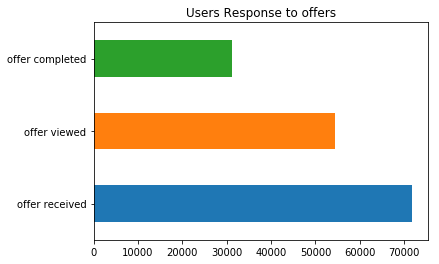

In [72]:
#Lets try to find the customer repsone to the offer
merged_df['event'].value_counts().plot.barh(title='Users Response to offers')


This implies that most of the customers didn't even see the offer and the rest of them saw the offer and ignored it . Only ver few of them saw the offer and availed it.

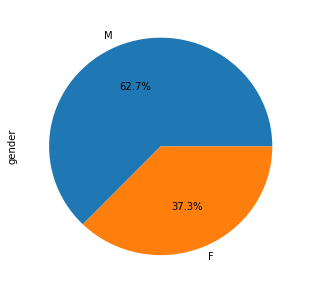

In [75]:
#Find the distribution of males and females
merged_df[merged_df['gender'] != 'O']['gender'].value_counts().plot(kind='pie',figsize=(5, 5),autopct='%1.1f%%')

It seems like most of the customers are actually male 

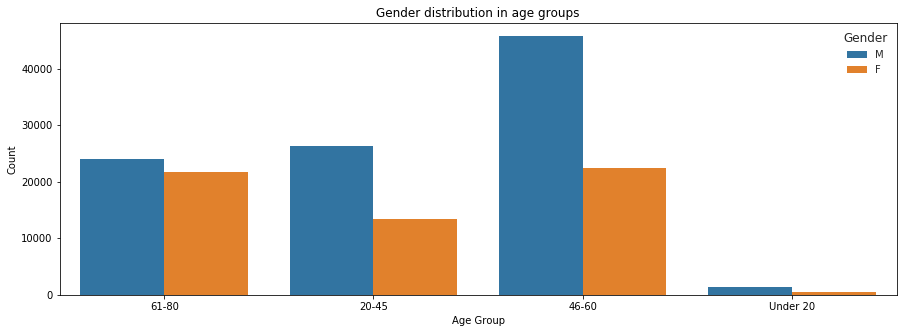

In [76]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender",data=merged_df[merged_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

There are more number of males then females in every age group

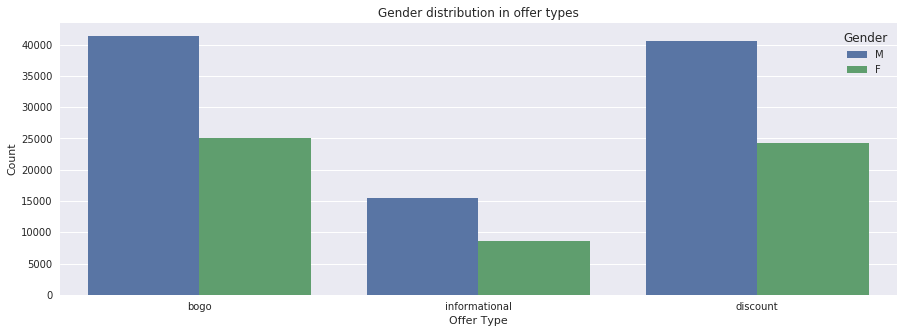

In [78]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=merged_df[merged_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

It seems like offers are sent in large numbers to males than females

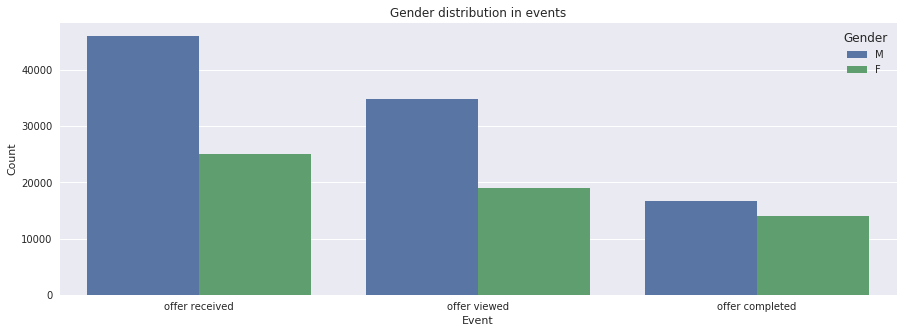

In [79]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=merged_df[merged_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Gender distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

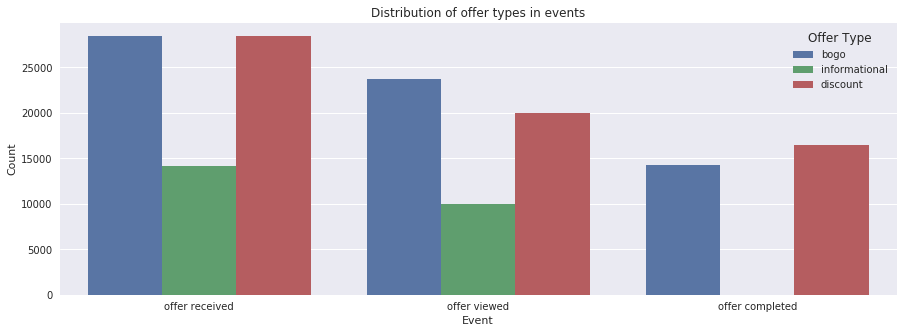

In [81]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_df[merged_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

So it seems that most customers availed the discount offer

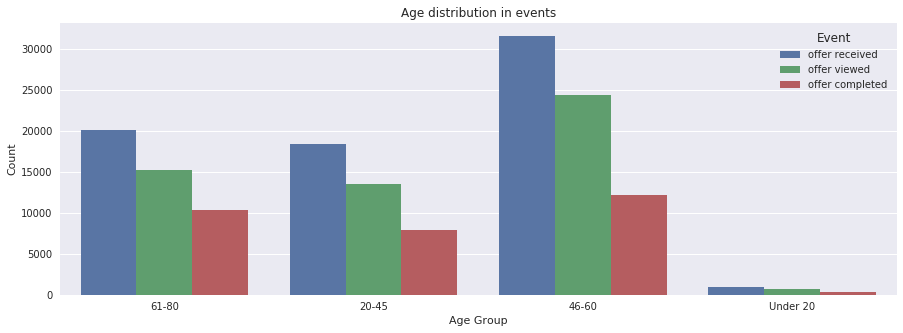

In [82]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "event", data=merged_df[merged_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Age distribution in events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

## 4. Data Modelling

In [83]:
#Now lets build a machine learning model to predict if the customer responds to an offer or not

We need to do few steps before building a machine learning model
    - Create dummy variables for all category variables
    - Replace the customer id and offer id with numeric values

In [84]:
def clean_merge_df(df):
    '''
    Cleans the merged dataframe
    
    Parameters: df(Data Frame)
    Returns a data frame
    '''
    #process categorical variables
    categorical = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical)
    #process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #process became_member_on column
    #change datatype of became_member_on 
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'amount_gained', 'amount_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [88]:
final_df = clean_merge_df(merged_df)

In [89]:
final_df.shape

(157503, 26)

In [91]:
final_df.columns

Index(['offer_difficulty', 'offer_duration', 'offer_id', 'offer_reward',
       'event', 'customer_id', 'time', 'amount_spent', 'amount_gained',
       'customer_income', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'gender_F', 'gender_M', 'gender_O',
       'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'email', 'mobile', 'social', 'web',
       'month_member', 'year_member'],
      dtype='object')

In [92]:
X = final_df.drop('event',axis=1)
y = final_df['event']

In [95]:
#Split the dataset into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=5)

In [96]:
assert(X_train.shape[0] == y_train.shape[0])

In [97]:
assert(X_test.shape[0] == y_test.shape[0])

In [106]:
#Now lets train and test the model
def build_model(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    clf: estimator instance
    
    Returns
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100 
    
    return train_f1, test_f1,clf.__class__.__name__

In [109]:
#Decision Tree Classifier
clf_1 = DecisionTreeClassifier(random_state=5)
clf_1_train,clf_1_test,clf_1_name = build_model(clf_1)

In [110]:
#Random Forest Classifier
clf_2 = RandomForestClassifier(random_state=5)
clf_2_train,clf_2_test,clf_2_name = build_model(clf_2)

In [113]:
#Now lets try this with the bench mark model
clf_3 = KNeighborsClassifier(5)
clf_3_train,clf_3_test,clf_3_name = build_model(clf_3)

## 5.Evaluate the Results

In [114]:
results_df = pd.DataFrame({'ModelName':[clf_1_name,clf_2_name,clf_3_name],
                           'train f1 score':[clf_1_train,clf_2_train,clf_3_train],
                            'test f1 score':[clf_1_test,clf_2_test,clf_3_test]})

In [117]:
results_df.head()

,ModelName,train f1 score,test f1 score
0,DecisionTreeClassifier,95.416980,85.151265
1,RandomForestClassifier,94.388419,70.737437
2,KNeighborsClassifier,54.372970,33.022761


- We Used F1 Score as a metric to evaluate the model.
- So based on the results we can say that both Random Forest Classifier and Decision Tree Classifier outperformed the K Nearest Neighbours (Bench Mark) Model.